# Nulos a gestionar

- **Price** -> Tiene 40 nulos (2%).
- **Discount** -> Tiene 40 nulos (2%).
- **Payment Method** -> Tiene 1753 nulos (87.65%)
- **Shipping Method** -> Tiene 1753 nulos (87.65%)
- **Customer Age** -> Tiene 40 nulos (2%).
- **Cupon Used** -> Tiene 1753 nulos (87.65%)


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer

In [75]:
df_o=pd.read_csv('../Data/data_limpios.csv')

In [76]:
df=df_o.copy()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2000 non-null   int64  
 1   group             2000 non-null   object 
 2   visit_date        2000 non-null   object 
 3   conversion        2000 non-null   int64  
 4   product_category  2000 non-null   object 
 5   product_id        2000 non-null   int64  
 6   product_name      2000 non-null   object 
 7   quantity          2000 non-null   int64  
 8   price             1960 non-null   float64
 9   discount          1960 non-null   float64
 10  total_value       2000 non-null   float64
 11  payment_method    247 non-null    object 
 12  shipping_method   247 non-null    object 
 13  region            2000 non-null   object 
 14  customer_age      1960 non-null   float64
 15  customer_gender   2000 non-null   object 
 16  device            2000 non-null   object 


In [ ]:
df.isnull().mean() *100

In [ ]:
df_nulos=df.loc[:,df.isnull().sum()>0]
df_nulos

### Nulos Categóricas

In [ ]:
for col in df_nulos.select_dtypes(include='O').columns:
  print(col.upper())
  display(df[col].value_counts()/df.shape[0]*100)
  print('----------')

In [79]:
def subplot_col_cat(dataframe):
  #Seleccionar las columas categóricas
  categorical_cols=dataframe.select_dtypes(include=['object','category']).columns
  if len(categorical_cols) == 0:
    return "No hay columnas categóricas"
  #Configurar el tamaño de la figura
  num_cols=len(categorical_cols)
  rows=(num_cols+2)//3 #Calcular filas necesarias para 3 columnas por fila
  fig,axes=plt.subplots(rows,3,figsize=(15,rows*5))
  axes=axes.flatten() #Convertir los ejes a un array de 1d plano para facilitar iteración

  #Generar gráficos para cada columna categórica
  for i,col in enumerate(categorical_cols):
    sns.countplot(data=dataframe, x=col,ax=axes[i],hue=col,palette="tab10",legend=False)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x',rotation=90) #Rotar etiquetas si es necesario

    #Eliminar ejes sobrantes si hay menos columnas que subplots
  for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

    #Ajustar diseño
  plt.tight_layout()
  plt.show()

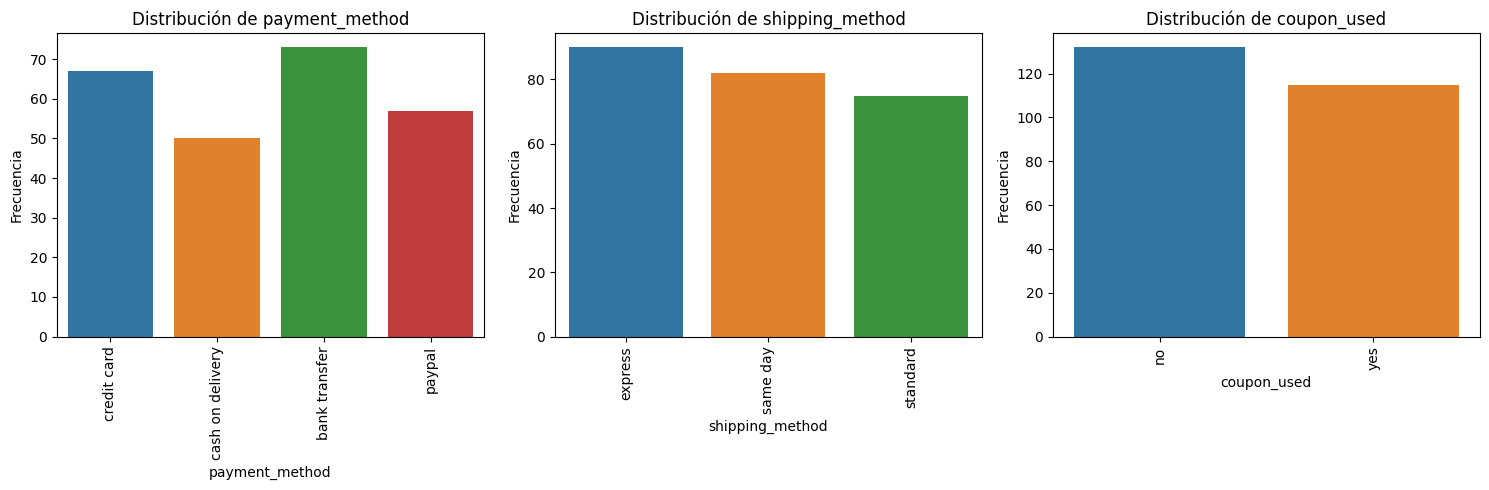

In [80]:
subplot_col_cat(df_nulos)

In [81]:
df_nulos.select_dtypes(include='O').isnull().mean()*100

payment_method     87.65
shipping_method    87.65
coupon_used        87.65
dtype: float64

### Se ha comprobado que los nulos de las columnas categóricas son debido a que no se ha realizado la compra, por lo tanto, no tienen método de pago, método de transporte ni se ha aplicado ningun cupón

In [82]:
df.loc[:,df.select_dtypes(include='O').columns]=df.select_dtypes(include='O').fillna('no_conversion')

In [83]:
df.isnull().mean()*100

user_id             0.0
group               0.0
visit_date          0.0
conversion          0.0
product_category    0.0
product_id          0.0
product_name        0.0
quantity            0.0
price               2.0
discount            2.0
total_value         0.0
payment_method      0.0
shipping_method     0.0
region              0.0
customer_age        2.0
customer_gender     0.0
device              0.0
session_duration    0.0
coupon_used         0.0
browser             0.0
referral_source     0.0
conversion_str      0.0
dtype: float64

# Outliers

In [84]:
def subplot_col_num(dataframe):
  #Seleccionar las columas categóricas
  col_num=dataframe.select_dtypes(include='number').columns
  num_graph=len(col_num)

  num_rows=(num_graph+2)//2

  fig,axes=plt.subplots(num_graph,2,figsize=(15,num_rows*5))

  #Generar gráficos para cada columna categórica
  for i,col in enumerate(col_num):
    sns.histplot(data=dataframe, x=col,ax=axes[i,0],bins=200)
    axes[i,0].set_title(f'Distribución de {col}')
    axes[i,0].set_xlabel(col)
    axes[i,0].set_ylabel('Frecuencia')

    sns.boxplot(data=dataframe, x=col,ax=axes[i,1])
    axes[i,1].set_title(f'Boxplot de {col}')

    #Eliminar ejes sobrantes si hay menos columnas que subplots
  for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

    #Ajustar diseño
  plt.tight_layout()
  plt.show()

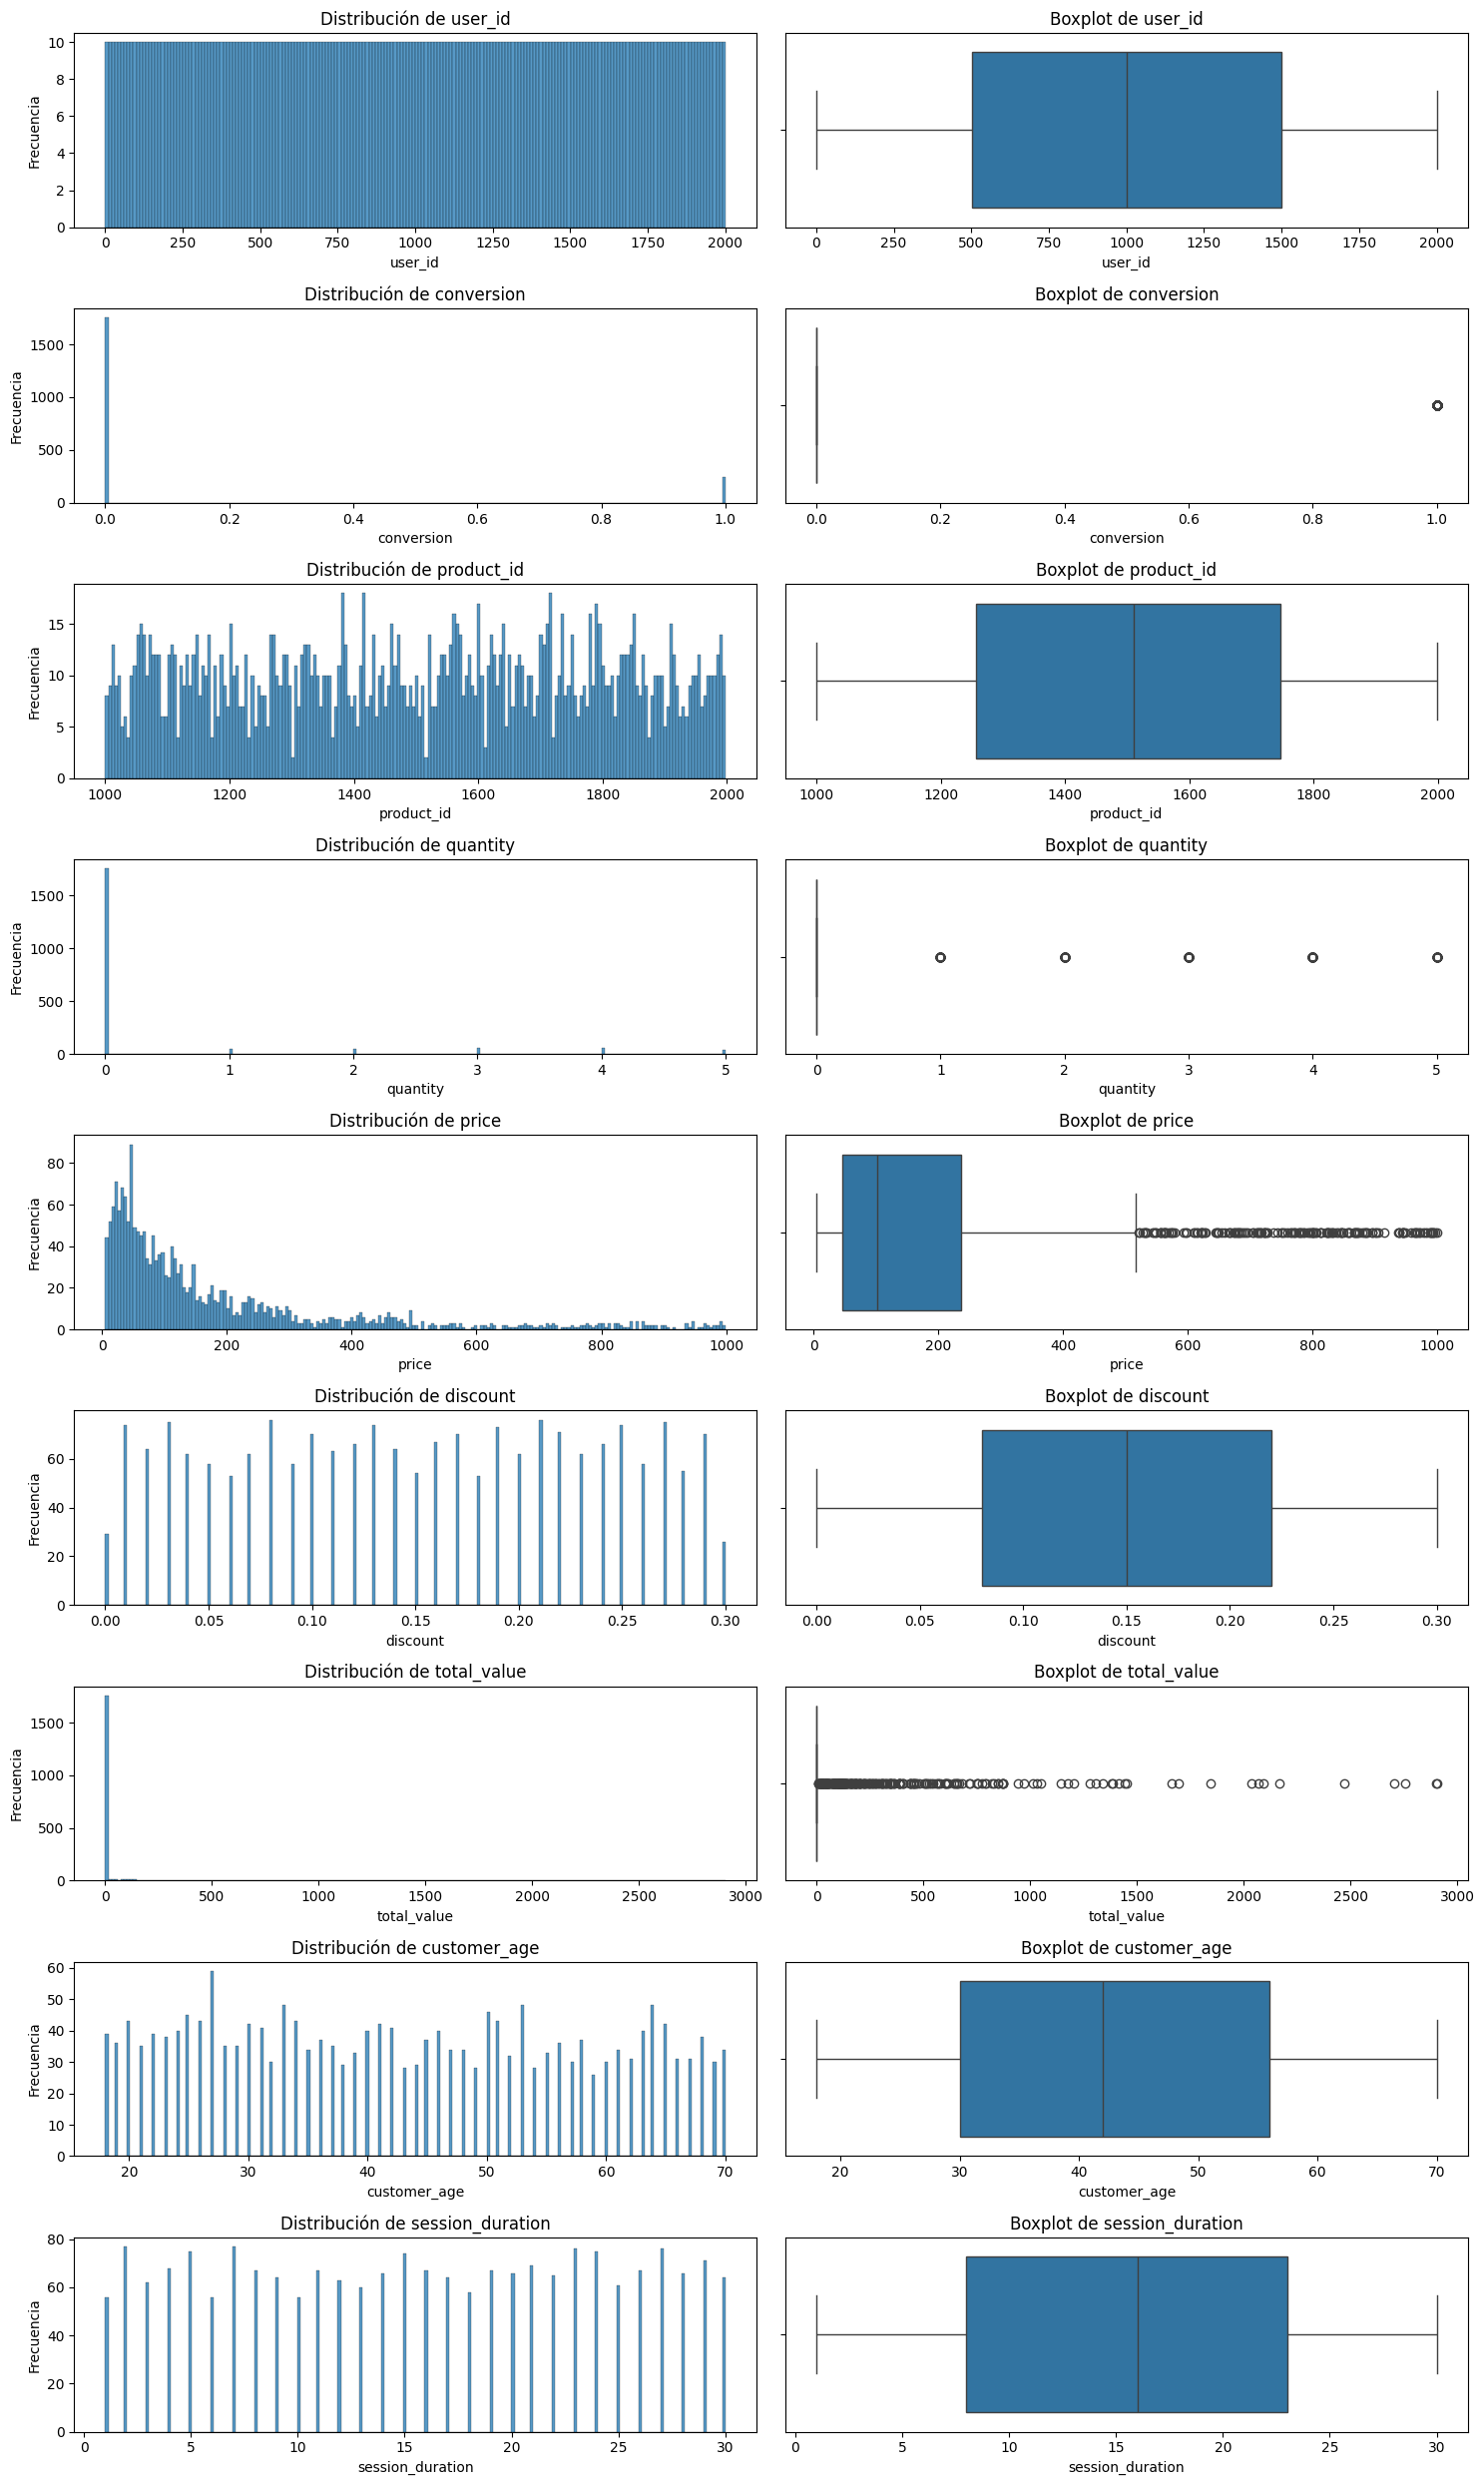

In [85]:
subplot_col_num(df)

# Columnas con Outliers: 
  - Price
  - Total_value

In [86]:
q_75=df['price'].quantile(0.75)
q_25=df['price'].quantile(0.25)
rango_itq=q_75-q_25

In [87]:
inferior=q_25-(rango_itq*1.5)
superior=q_75+(rango_itq*1.5)

In [88]:
def calculo_outliers(df,cols):
  for col in cols:
    q_75=df[col].quantile(0.75)
    q_25=df[col].quantile(0.25)
    rango_itq=q_75-q_25
    inferior=q_25-(rango_itq*1.5)
    superior=q_75+(rango_itq*1.5)

    outliers=df[(df[col]>superior) | (df[col]<inferior)]
    num_outliers=len(outliers)
    per_outliers=num_outliers/df.shape[0]*100

    print(f'En la column {col.upper()} tenemos un total de {num_outliers} outliers, que representa un {per_outliers} % del total')

In [69]:
calculo_outliers(df,['price','total_value'])

En la column PRICE tenemos un total de 161 outliers, que representa un 8.05 % del total
En la column TOTAL_VALUE tenemos un total de 247 outliers, que representa un 12.35 % del total


# Nulos Categóricas

In [91]:
df_nulos.select_dtypes(include='number').isnull().mean()*100

price           2.0
discount        2.0
customer_age    2.0
dtype: float64

In [44]:
df_nulos.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1960.0,184.572138,211.981538,5.02,46.0925,102.465,236.155,998.88
discount,1960.0,0.150224,0.086591,0.00,0.0800,0.150,0.220,0.30
customer_age,1960.0,43.156633,15.361675,18.00,30.0000,42.000,56.000,70.00


In [90]:
df_filled_simple=df.fillna({'discount':df['discount'].mean(),
                            'customer_age':df['customer_age'].median()})

In [92]:
def imputar_iterative(dataframe, lista_columnas):
    iter_imputer = IterativeImputer(max_iter=50, random_state=42)
    data_imputed = iter_imputer.fit_transform(dataframe[lista_columnas])
    new_col = [col + "_iterative" for col in lista_columnas]
    dataframe[new_col] = data_imputed
    return dataframe

In [95]:
def imputar_knn(dataframe, lista_columnas):
    knn_imputer = KNNImputer(n_neighbors=5)
    data_imputed = knn_imputer.fit_transform(dataframe[lista_columnas])
    new_col = [col + "knn" for col in lista_columnas]
    dataframe[new_col] = data_imputed
    return dataframe

In [ ]:
df_filled_simple= imputar_iterative(df_filled_simple,['price'])
df_filled_simple.sample()

In [ ]:
df_filled_simple.isnull().sum()

In [96]:
df_filled_simple= imputar_knn(df_filled_simple,['price'])
df_filled_simple.sample()

,user_id,group,visit_date,conversion,product_category,product_id,product_name,quantity,price,discount,...,customer_age,customer_gender,device,session_duration,coupon_used,browser,referral_source,conversion_str,price_iterative,priceknn
825,826,b,2022-01-23,0,toys,1701,puzzle,0,53.52,0.1,...,42.0,m,desktop,29,no_conversion,other,social,no,53.52,53.52


In [97]:
df_filled_simple.isnull().sum()

user_id              0
group                0
visit_date           0
conversion           0
product_category     0
product_id           0
product_name         0
quantity             0
price               40
discount             0
total_value          0
payment_method       0
shipping_method      0
region               0
customer_age         0
customer_gender      0
device               0
session_duration     0
coupon_used          0
browser              0
referral_source      0
conversion_str       0
price_iterative      0
priceknn             0
dtype: int64

In [99]:
df_filled_simple[['price','price_iterative','priceknn']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,1960.0,184.572138,211.981538,5.02,46.0925,102.465,236.1550,998.88
price_iterative,2000.0,184.572138,209.849945,5.02,46.7975,106.810,231.7425,998.88
priceknn,2000.0,184.572138,209.849945,5.02,46.7975,106.810,231.7425,998.88


In [100]:
df_filled_simple.drop(columns=['price','price_iterative'],inplace=True)

In [ ]:
df_filled_simple.isnull().sum()

In [102]:
df_filled_simple.to_csv('../Data/data_limpios_nonulos.csv',index=False)